In [4]:
from math import pi, sqrt
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import elementary_charge
from pytexit import py2tex
from scipy.stats import gaussian_kde
from tabulate import tabulate

MDa = 1.6605e-21 #kg
nm = 1e-9

In [5]:
#[Lauffer 1944]: diameter 109 +/- 16.65 nm
#[Ruigrok 1984]: diameter 115 +/- 12 nm

mean_diameter = (109.0+115.0)/2.0

sigma_diameter = (16.65+12)/2.0 #average

#[Ruigrok 1984]: mass 160 MDa +/- 17 MDa
sigma_mass = (17.0+24.0)/2.0

mean_mass = 160


In [6]:
#check if variation in  variation in volume corresponds to the variation in mass
# mass is only 
avg_radius = 57.5 
one_sigma_pos_rad = avg_radius + (sigma_diameter/2.0)
volume_sigma = (((4/3.0) * pi * (one_sigma_pos_rad)**2.0)/((4/3.0) * pi * (avg_radius)**2.0))-1.0
volume_sigma
avg_mass = 75.0
vol_one_sigma_mass = avg_mass*volume_sigma
vol_one_sigma_mass
#it doesn't

19.84851961247638

We know the variation in the diameter and therefore that in the volume. There is, surprisingly, almost no variation in the total spike mass, so we subtract that first. We would expect $\sigma = 19.8$ MDa variation if volume and mass were proportional, and see $\sigma = 17$ MDa of variation. 

We therefore assume that mass and volume are proportional.



In [7]:
#Extracted from [Li 2011] using https://apps.automeris.io/wpd/,

# count = np.array([2.9816513761467904,
# 6.0091743119266035,
# 15.045871559633028,
# 21.14678899082569,
# 17.93577981651376,
# 11.10091743119266,
# 11.972477064220184,
# 11.972477064220184,
# 15.458715596330272,
# 8.119266055045873,
# 19.174311926605505,
# 9.908256880733944,
# 6.834862385321103,
# 5.045871559633027,
# 7.018348623853214,
# 2.018348623853214,
# 1.0091743119266046])

breaking_force_count = np.array([ 3.,  6., 15., 21., 18., 11., 12., 12., 15.,  8., 19., 10.,  7.,
        5.,  7.,  2.,  1.]) #rounded


breaking_force_bins = [0.24179620034542312,
0.33851468048359246,
0.4421416234887737,
0.5423143350604491,
0.6528497409326425,
0.753022452504318,
0.8186528497409327,
0.9395509499136444,
1.0466321243523315,
1.143350604490501,
1.2469775474956826,
1.3506044905008636,
1.4300518134715028,
1.5474956822107082,
1.6165803108808294,
1.7305699481865287,
1.9412780656303976] # bin midpoints


In [8]:
N = 5000

### Fitting breaking force with gaussian - doesn't work particularly well


In [9]:

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

popt, _ = curve_fit(gaussian, breaking_force_bins, breaking_force_count)
mean_breaking_force = popt[0]
sigma_breaking_force = abs(popt[2]) #curve_fit can sometimes return negative.

print("Liposome breaking force mean={:.3f} sigma={:.3f} pN".format(mean_breaking_force, sigma_breaking_force))

#this could also include some of the non-infective mutants

Liposome breaking force mean=0.839 sigma=0.733 pN


In [10]:
#overriding with tweaked values because non-bimodal
# mean_breaking_force = 0.839
# sigma_breaking_force = 0.45

In [11]:

weights = (breaking_force_count/np.sum(breaking_force_count))
resamples = np.random.choice(breaking_force_bins, size=N, p=weights)

breaking_force_kernel = gaussian_kde(resamples)
# breaking_force_kernel.set_bandwidth(0.5)


In [12]:
mean_charge = 1e7
sigma_charge = 1e5 #placeholder - fixme

Now we run into a problem. We don't know the dependence of k, the spring constant, on any of the parameters in an actual virus. It is determined by the strength of the intermolecular forces and is a free parameter.

From [Li 2011], Figure 3a we see that the empty liposome stiffness is negatively correlated with size; but the stiffness of the empty liposome appears to be hundreds of times smaller than that of the full virion.

From running ensembles with different values of k_sigma, while the distribution of the resonant frequencies is very sensitive to this parameter, the inactivation threshold is not; so we guess a resonable figure.

Figure 4b in Yang is dependent on k vs f_res, and the overall absorption cross-section data in Figure 3b includes the sum of all the absorption cross-sections of all the variance. It is likely possible to extract the remaining data from these plots; but, since none of this is applicable to SARS-NCoV, this exceeds our patience.

The upshot is that all the resonant frequency distributions below are just guesses. 

In [13]:
mean_mu = 14.5 * MDa 
mean_k = ((2.0 * pi * 8.2e9)**2.0) * mean_mu #from [Yang]

sigma_spring_constant = (0.07*mean_k)/sigma_diameter # nN / nm


In [14]:
means = [mean_diameter, mean_mass, mean_breaking_force, mean_charge, mean_k] #oh he's got the means all right.

var_diameter = (sigma_diameter**2.0) #variance is the square of the standard deviation.
var_mass = (sigma_mass**2.0) #inertia is a property of matter.
var_breaking_force = (sigma_breaking_force**2.0)
var_charge = (sigma_charge**2.0)
var_spring_constant = (sigma_spring_constant**2.0)


#diameter varies with diameter, varies with mass, with breaking force, and with charge
cov_diameter =        [var_diameter, sigma_diameter*sigma_mass*0.95, 0, 0, 0]

cov_mass =            [sigma_diameter*sigma_mass*0.95, var_mass, 0, 0, 0]

cov_breaking_force =  [0, 0, var_breaking_force, 0, 0]

cov_charge =          [0, 0, 0, var_charge, 0]

cov_spring_constant = [0, 0, 0, 0, var_spring_constant]


covariance_matrix = [cov_diameter, 
                     cov_mass,
                     cov_breaking_force,
                     cov_charge,
                     cov_spring_constant]




covariance_matrix = np.array(covariance_matrix) #must be symmetric positive semidefinite;
#eigenvalues must be 

diameter_samples,mass_samples,breaking_force_samples,charge_samples, spring_constant_samples\
                = np.random.multivariate_normal(means, covariance_matrix, N).T


diameter_samples = diameter_samples.T #first .T lets us access with ,, operator, second .T gets us our 1d array back
mass_samples = mass_samples.T
breaking_force_samples = breaking_force_samples.T 
charge_samples = charge_samples.T 
spring_constant_samples = spring_constant_samples.T 




The liposome breaking force is distributed in an obstinately non-gaussian bimodal manner, so we override the covariance matrix and introduce a gaussian KDE sampled from the force histogram in [Li 2011].

In [15]:
#ignore the above covariant normal breaking forces, resample from KDE
breaking_force_samples = gaussian_kde.resample(breaking_force_kernel, N).T

0

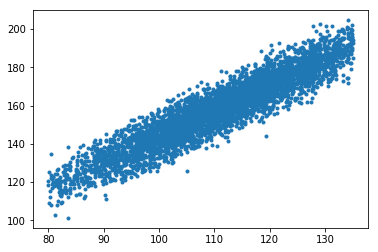

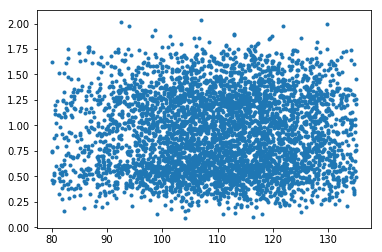

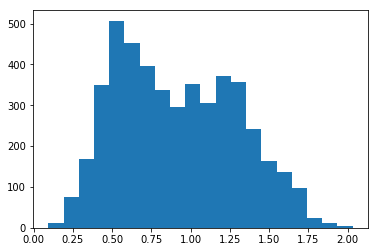

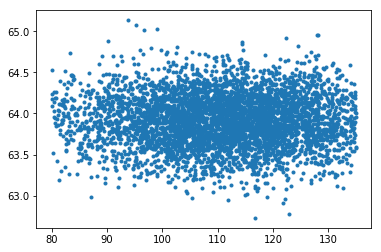

In [16]:

#choose only infectious particles [Lauffer 1944]
remove_indices = np.append(np.nonzero((diameter_samples < 80.0)), np.nonzero((diameter_samples > 135.0)))

#choose only positive breaking forces
remove_indices = np.append(remove_indices, np.nonzero(breaking_force_samples < 0.0))

remove_indices = np.unique(remove_indices)

diameter_samples = np.delete(diameter_samples, remove_indices)
mass_samples = np.delete(mass_samples, remove_indices)
breaking_force_samples = np.delete(breaking_force_samples, remove_indices)
charge_samples = np.delete(charge_samples, remove_indices)
spring_constant_samples = np.delete(spring_constant_samples, remove_indices)


plt.plot(diameter_samples,mass_samples, '.')
plt.figure()
plt.plot(diameter_samples,breaking_force_samples, '.')

#> "More than 95% puncture events occurred above 0.4 nN."
above_point_4 = np.shape(np.where(breaking_force_samples > 0.4))[1] / len(breaking_force_samples)
# probably because of the clipped normal. np multivariate doesn't support beyond normal,
# so that'll have to be good enough.
# altered distribution to better fit breaking force; now it's 92%

plt.figure()
plt.hist(breaking_force_samples,20)

plt.figure()
plt.plot(diameter_samples, spring_constant_samples, '.')

above_point_4

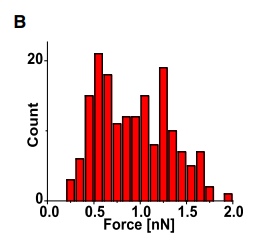

In [17]:
# convert everything to base SI

diameter_samples *= 1e-9 # nm
mass_samples *= MDa #MDa
breaking_force_samples *= 1e-9 #nN
charge_samples *= elementary_charge

# afm pressure
afm_tip_radius = 30e-9 #m
afm_area = pi*(afm_tip_radius**2.0)

breaking_stress_samples = breaking_force_samples / afm_area # now to Pa


We very simply extend [Yang 2015]'s analysis to include the distribution of viral particles. 

We have to continue using Inf. A rather than the target SARS-NCoV-2 because of an apparent lack of AFM nanoindentation data. While both virions have a lipid bilayer 

    The majority of virions (n = 78) may be described as spherical (axial ratio 1.2), the remainder are oval or   kidney-shaped with axial ratios up to 1.4 (n = 17) or more elongated with axial ratios as high as 7.7 (n = 15). The outer diameters of the spherical virions ranged from 84 to 170 nm (mean, 120 nm).

Note that, per [Lauffer 1944], of Inf A and B, "the infectious particles have diameters within the range 80 to 135[nm]".

[Yang 2015]'s MDCK plaque assay is already sensitive to infectivity; the extreme-sized non-infective mutants would already be filtered out. Their PCR assay might not be; the DNA of all non-infectious mutants would be considered.

[Yang 2015] use a minimum force of 400 pN, though their reference, [Li 2011], mention that

> More than 95% puncture events occurred above 0.4 nN.

This probably accounts for the high 100% threshold.

The distribution of breaking strengths in [Li 2011] (Figure 5b) is bimodal, and a naive gaussian fit does not produce the above 95% figure. Rather than implement a unimodal+bimodal covariant sampling function, we tweaked the gaussian parameters to accordingly. We hope that the deities of statistical best practice are not displeased.

The mass, diameter, and breaking force are presumably not independently distributed. The correlations between the three variables do not seem to be documented in the literature.

[Li 2011], the AFM data is from [H1N1] rather than the H3N1 or H5N1.

We therefore need the CoV for NCoV.

There seems to be little variation in the mass of the spike proteins; intact H3N1 is 161 MDa +/- 17, with spikes removed, 75 MDa +/- 17.  [Ruigrok 1984]  

Influenza is found in two different morphologies; the one found in the lab is almost entirely the spherical variant, whereas filamentous variant is often associated with infections in humans. Because it is rare in the lab, this is not part of the cause of [Yang 2015]'s discrepancy; and NCoV does not seem to exhibit such pleomorphic tendencies.

The average stiffness of the liposome varies approximately linearly from 0.025 to 0.015 from 80 to 135 nm [Li 2011], plus a random distribution with approx. 0.0025 sigma. 

Size and weight are assumed to be uncorrelated with breaking strength.


From [Yang 2015], eq. 7,

$$A = \frac{q E_0}{\mu \sqrt{((2 \pi f_{res})^2 - (2 \pi f_{excite})^2)^2 + \left(\frac{(2 \pi f_{res})(2 \pi f_{excite})}{Q}\right)^2}}$$


The resonant frequency varies as $\sqrt{k/m^*}$.

Assuming (as Yang et al do) that the core and shell have 90% and 10% of the mass, 



In [18]:
reduced_masses_mu = ((0.9*mass_samples) * (0.1*mass_samples))/(mass_samples) 

In [19]:
resonant_frequencies = np.sqrt(spring_constant_samples/reduced_masses_mu)/(2.0*pi)

Text(0,0.5,'Count')

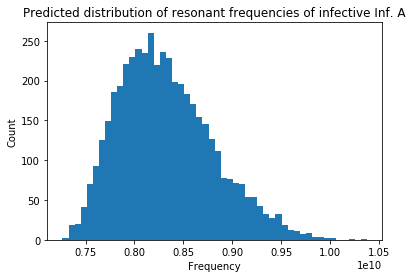

In [20]:
plt.hist(resonant_frequencies, 50)
plt.title("Predicted distribution of resonant frequencies of infective Inf. A")
plt.ticklabel_format(style='sci', axis='x', scilimits=(9,9))
plt.xlabel("Frequency")
plt.ylabel("Count")

Unfortunately, this distribution is very sensitive to the values of k 

A surprising source the sadists that drag cracked virions through acrylamide gel and then irradiate them for sport. 

Two dimensional gel electrophoresis resolves both the mass and the isoelectric point (where the net charge and that of the solution are in equilibrium) of large structures. [Privalsky 1978] provides us a coarse. view of the charges and relative abundances in the virus. 


'NP has MW 60000 Da'

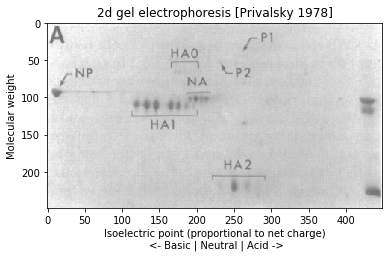

In [21]:
from PIL import Image

im = Image.open('../media/Inf_A_2d_gel_Privalsky.png') # Can be many different formats.
pix = im.load()


plt.imshow(im)
plt.title("2d gel electrophoresis [Privalsky 1978]")
plt.xlabel("Isoelectric point (proportional to net charge)\n <- Basic | Neutral | Acid ->")
plt.ylabel("Molecular weight")

"NP has MW 60000 Da"

There's substantial hetrogeneity in the charge of the proteins with the exception of the nucleocapsid protein NP. The M proteins have run off the basic end. The followup work [Privalsky 1980] indeed finds the M protein to be very basic. [Shtykova 2017] discusses the charge on the M1 matrix protein.

confusingly, there are two different M proteins, sometimes called "M" and sometimes called "M1".


[Bosch 1984] discusses the charge hetrogenetity a bit, but not quite relevant. 


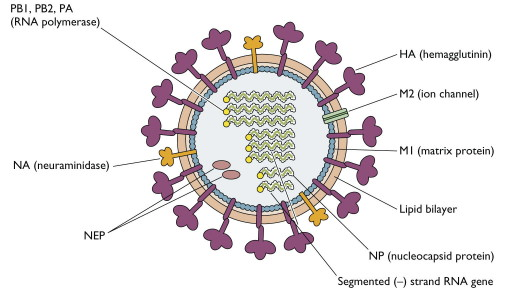

From https://www.virology.ws/2009/04/30/structure-of-influenza-virus/, CC-BY-3.0

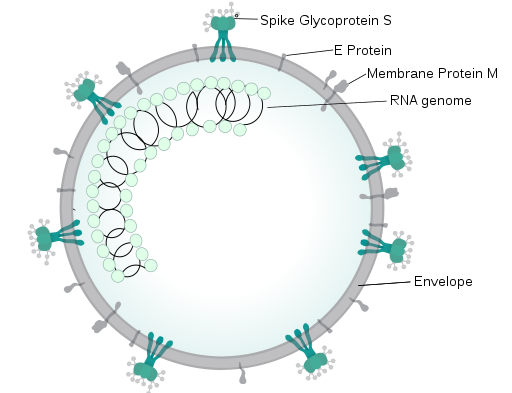

https://commons.wikimedia.org/wiki/File:Coronavirus_virion_structure.svg

In [22]:
excitation_frequency = 8.3e9

Q = 2.0 # also assumed to be invariant

In [23]:
def percentiles(inp):
    for i in [6, 25, 38, 50, 63, 75, 90, 99.9]:
        
        print("{}th percentile: {:2f}".format(i, np.percentile(inp, i, axis=0)))


6th percentile: 107.012797
25th percentile: 177.212743
38th percentile: 221.679642
50th percentile: 267.026654
63th percentile: 322.620859
75th percentile: 387.506921
90th percentile: 506.625379
99.9th percentile: 886.655556


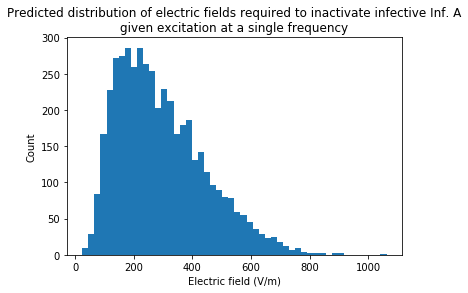

In [25]:
af = 2.0*pi

def electric_field_threshold(i, excitation_frequency):
    t1 = breaking_stress_samples[i] * pi * ((diameter_samples[i] / 2.0)**2.0)

    t2 = np.sqrt((reduced_masses_mu[i]**2.0) * (((((resonant_frequencies[i]*af)**2.0)) - ((excitation_frequency*af)**2.0))**2.0)\
            + ((((resonant_frequencies[i]*af)*reduced_masses_mu[i])/Q)**2.0) * ((excitation_frequency*af)**2.0))
    b = 3.45 * charge_samples[i] * reduced_masses_mu[i] * ((resonant_frequencies[i]*af))**2.0

    electric_field_thresholds = (t1 * t2) / b
    
    return electric_field_thresholds

#eq 12 in [Yang 2015]
def electric_field_thresholds(excitation_frequency):

    t1 = breaking_stress_samples * pi * ((diameter_samples / 2.0)**2.0)

    t2 = np.sqrt((reduced_masses_mu**2.0) * (((((resonant_frequencies*af)**2.0)) - ((excitation_frequency*af)**2.0))**2.0)\
            + ((((resonant_frequencies*af)*reduced_masses_mu)/Q)**2.0) * ((excitation_frequency*af)**2.0))
    b = 3.45 * charge_samples * reduced_masses_mu * ((resonant_frequencies*af))**2.0

    electric_field_thresholds = (t1 * t2) / b
    
    return electric_field_thresholds

single_freq_elecric_field_thresholds = electric_field_thresholds(excitation_frequency)

plt.title("Predicted distribution of electric fields required to inactivate infective Inf. A\n"+\
        "given excitation at a single frequency")
plt.hist(single_freq_elecric_field_thresholds, 50)
plt.xlabel("Electric field (V/m)")
plt.ylabel("Count")
percentiles(single_freq_elecric_field_thresholds)

# Yang get:
# 100%: 275 V/m
# 63%: 171 V/m
# 38%: 87 V/m
# 6%: 68 V/m




IEEE et al appear to specify power densities as those in free space, a small distance from the body:



$$S = \frac{|E|^2}{Z_0}$$

6th percentile: 30.375965
25th percentile: 83.300679
38th percentile: 130.349773
50th percentile: 189.133247
63th percentile: 276.085467
75th percentile: 398.306669
90th percentile: 680.820359
99.9th percentile: 2085.316060


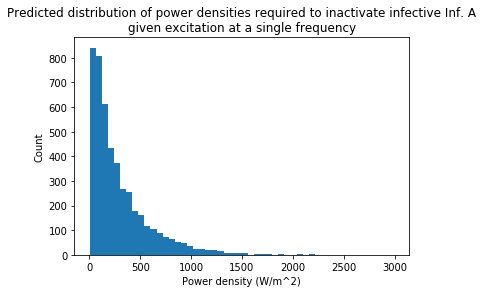

In [28]:
single_freq_power_densities = (single_freq_elecric_field_thresholds**2.0) / 377.0

plt.title("Predicted distribution of power densities required to inactivate infective Inf. A\n"+\
        "given excitation at a single frequency")
plt.hist(single_freq_power_densities, 50)
plt.xlabel("Power density (W/m^2)")
plt.ylabel("Count")
percentiles(single_freq_power_densities)

In [ ]:
for i in np.random.choice(range(0,len(resonant_frequencies)), size = 20):

    freqs = np.linspace(1e9,15e9)
    plt.plot(freqs,electric_field_threshold(i, freqs),'b')
    plt.title("Electric field threshold of a sample of virions against excitation frequency")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(9,9))
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Theshold (V/m)")
    
    optimal_excitation_frequency = (sqrt(2.0 * Q**2.0 - 1.0) * (2.0*pi*resonant_frequencies[i])) / ((sqrt(2.0)*Q)) / (2.0*pi)
    print(optimal_excitation_frequency)

The resonant frequency does not necessarily correspond to the optimal excitation frequency. The positive critical point of (12) is

$$w = \frac{\sqrt{2 Q^2 - 1} f_{res}}{\sqrt{2} \ Q}$$


In [ ]:

optimal_excitation_frequencies = (sqrt(2.0 * Q**2.0 - 1.0) * (2.0*pi*resonant_frequencies)) / ((sqrt(2.0)*Q)) / (2.0*pi)

plt.subplot()
plt.hist(optimal_excitation_frequencies, 50)
plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(9,9))


In [ ]:
sweep_thresholds = electric_field_thresholds(optimal_excitation_frequencies)

#plt.hist(thresholds, 50)

# percent_under(sweep_thresholds, 200.0)

plt.hist(single_freq_thresholds-sweep_thresholds, 100)

print("Given a frequency sweep in which each virion is excited with its frequency of maximum power dissipation,")
print("The following threshold percentiles would be expected:")
percentiles(sweep_thresholds)


percentiles(single_freq_thresholds-sweep_thresholds)
